# pl

> Phase Linking

<!-- Phase linking for PTA requires `cupy.optimize` to be implented which is tracked at
https://github.com/rapidsai/raft/pull/923
and https://github.com/cupy/cupy/issues/6112 -->

In [ ]:
#| default_exp pl

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| code-fold: true
#| code-summary: "Code for generating data for test and doc"

import cupy as cp
import numpy as np
import zarr
import h5py
from decorrelation.shp import ks_test
from decorrelation.co import emperical_co,emperical_co_sp, regularize_spectral

from matplotlib import pyplot as plt

In [ ]:
#| export
import cupy as cp

## EMI

In [ ]:
#| hide
# This function is now deprecated
def emi_all(coh:cp.ndarray, #coherence ,dtype cupy.complex
       )-> tuple[cp.ndarray,cp.ndarray,cp.ndarray]: # estimated phase history `ph`, dtype complex; estimated covariance, dtype complex; minimum eigvalue, dtype float
    coh_mag = abs(coh)
    coh_mag_inv = cp.linalg.inv(coh_mag)
    min_eigval, min_eig = cp.linalg.eigh(coh_mag_inv*coh)
    min_eigval = min_eigval[...,0]
    min_eig = min_eig[...,0]
    min_eig = min_eig*cp.sqrt(min_eig.shape[-1])/cp.linalg.norm(min_eig,axis=-1)[...,None] # equality constrain
    min_eig = 1/min_eig.conj()
    abs_min_eig = abs(min_eig)

    estimated_coh = min_eigval[:,None,None]*coh_mag*cp.matmul(min_eig[...,None],min_eig[...,None,:].conj())
    return min_eig/abs_min_eig, estimated_coh, min_eigval

In [ ]:
#| export
def emi(coh:cp.ndarray, #complex coherence metrix,dtype cupy.complex
       )-> tuple[cp.ndarray,cp.ndarray]: # estimated phase history `ph`, dtype complex; quality (minimum eigvalue, dtype float)
    coh_mag = abs(coh)
    coh_mag_inv = cp.linalg.inv(coh_mag)
    min_eigval, min_eig = cp.linalg.eigh(coh_mag_inv*coh)
    min_eigval = min_eigval[...,0]
    min_eig = min_eig[...,0]

    return min_eig/abs(min_eig), min_eigval

`emi` is a phase estimator base on Eigendecomposition-based Maximum-likelihood-estimator of Interferometric phase (EMI) [@ansariEfficientPhaseEstimation2018] phase linking method.

The amplitude of `coh` should range between 0 and 1 and the phase of `coh` should be the interferometric phase.
The returned phase is also complex but the amplitude is setted to 1.
The quality factor is a measure for the inadequacy of EMI's model that adding real-valued dyadic for calibration of real coherence matrix which is generally poorly estimated.
It is supposed to larger than 1 and smaller means better.

Example:
Complex coherence matrix from a stack of 17 SLC images:

In [ ]:
#| code-fold: true
#| code-summary: "Code for generating data for test and doc"

rslc = zarr.open('../../data/rslc.zarr/','r')
rslc = cp.asarray(rslc[:])

# SHP selection
az_half_win = 5; r_half_win = 5
az_win = 2*az_half_win+1; r_win = 2*r_half_win+1

rmli = cp.abs(rslc)**2
sorted_rmli = cp.sort(rmli,axis=-1)
del rmli
dist,p = ks_test(sorted_rmli,az_half_win=az_half_win,r_half_win=r_half_win)
is_shp = (p < 0.05) & (p >= 0.0)
del p

# Select DS candidate
shp_num = cp.count_nonzero(is_shp,axis=(-2,-1))
is_ds_can = shp_num >= 50

ds_can_is_shp = is_shp[is_ds_can]
ds_can_idx = cp.where(is_ds_can)
ds_can_cov, ds_can_coh = emperical_co_sp(rslc,ds_can_idx,ds_can_is_shp)

In [ ]:
ds_can_coh.shape

(740397, 17, 17)

In [ ]:
ds_can_ph, ds_can_emi_quality = emi(ds_can_coh)
ds_can_ph.shape, ds_can_emi_quality.shape

((740397, 17), (740397,))

In [ ]:
ds_can_emi_quality_2d = cp.empty_like(is_ds_can,dtype=ds_can_emi_quality.dtype)
ds_can_emi_quality_2d[:] = cp.nan
ds_can_emi_quality_2d[is_ds_can] = ds_can_emi_quality

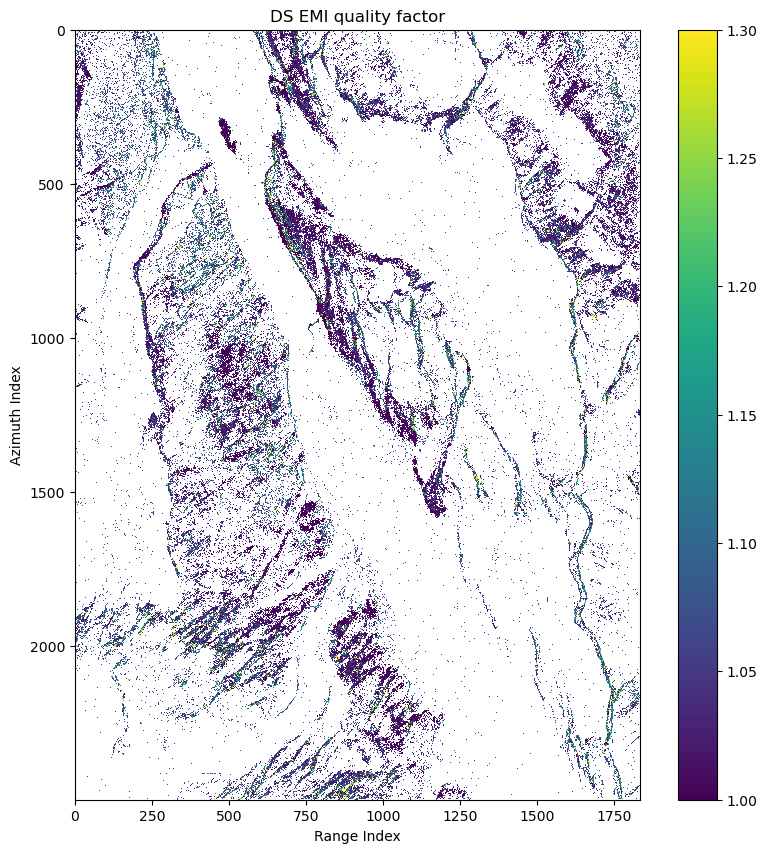

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
pcm = ax.imshow(cp.asnumpy(ds_can_emi_quality_2d),interpolation='nearest',vmin=1,vmax=1.3)
ax.set(title='DS EMI quality factor',xlabel='Range Index',ylabel='Azimuth Index')
fig.colorbar(pcm)
fig.show()

## Temporal Coherence for Distributed Scatterer

In [ ]:
#| export
def temp_coh(coh:cp.ndarray,# complex coherence metrix, dtype cupy.complex
             ds_ph = cp.ndarray, # complex phase history, dtype cupy.complex
            ):
    nimages = ds_ph.shape[-1]
    assert coh.shape[-2:] == (nimages,nimages), "input dimension not match"
    ds_ph = ds_ph/abs(ds_ph)
    coh = coh/abs(coh)
    int_ph = ds_ph[...,None]*ds_ph[...,None,:].conj()
    diff_ph = coh*int_ph.conj()
    t_coh = (cp.sum(diff_ph,axis=(-2,-1))-cp.trace(diff_ph,axis1=-2,axis2=-1)).real/(nimages**2-nimages)
    return t_coh

This function estimate the temporal coherence of DSs which is defined as [@ferrettiNewAlgorithmProcessing2011]:

$$\gamma = \frac{1}{N^2-N} \sum_{n=1}^{N} \sum_{k \neq n}^{N} e^{i\phi_{nk}} e^{-i(\theta_n-\theta_k)}$$

Where $\phi_{nk}$ is the phase of complex coherence matrix and $\theta_{n}$ is the phase after phase linking.

In [ ]:
#| code-fold: true
#| code-summary: "Code for generating data for test and doc"

rslc = zarr.open('../../data/rslc.zarr/','r')
rslc = cp.asarray(rslc[:])

# SHP selection
az_half_win = 5; r_half_win = 5
az_win = 2*az_half_win+1; r_win = 2*r_half_win+1

rmli = cp.abs(rslc)**2
sorted_rmli = cp.sort(rmli,axis=-1)
del rmli
dist,p = ks_test(sorted_rmli,az_half_win=az_half_win,r_half_win=r_half_win)
is_shp = (p < 0.05) & (p >= 0.0)

# Select DS candidate
shp_num = cp.count_nonzero(is_shp,axis=(-2,-1))
is_ds_can = shp_num >= 50

ds_can_is_shp = is_shp[is_ds_can]
ds_can_idx = cp.where(is_ds_can)
ds_can_cov, ds_can_coh = emperical_co_sp(rslc,ds_can_idx,ds_can_is_shp)
ds_can_ph = emi(ds_can_coh)[0]

In [ ]:
ds_can_coh.shape,ds_can_ph.shape

((740397, 17, 17), (740397, 17))

In [ ]:
ds_can_temp_coh = temp_coh(ds_can_coh,ds_can_ph)
ds_can_temp_coh.shape

(740397,)

In [ ]:
ds_can_temp_coh_2d = cp.empty_like(is_ds_can,dtype=ds_can_temp_coh.dtype)
ds_can_temp_coh_2d[:] = cp.nan
ds_can_temp_coh_2d[is_ds_can] = ds_can_temp_coh

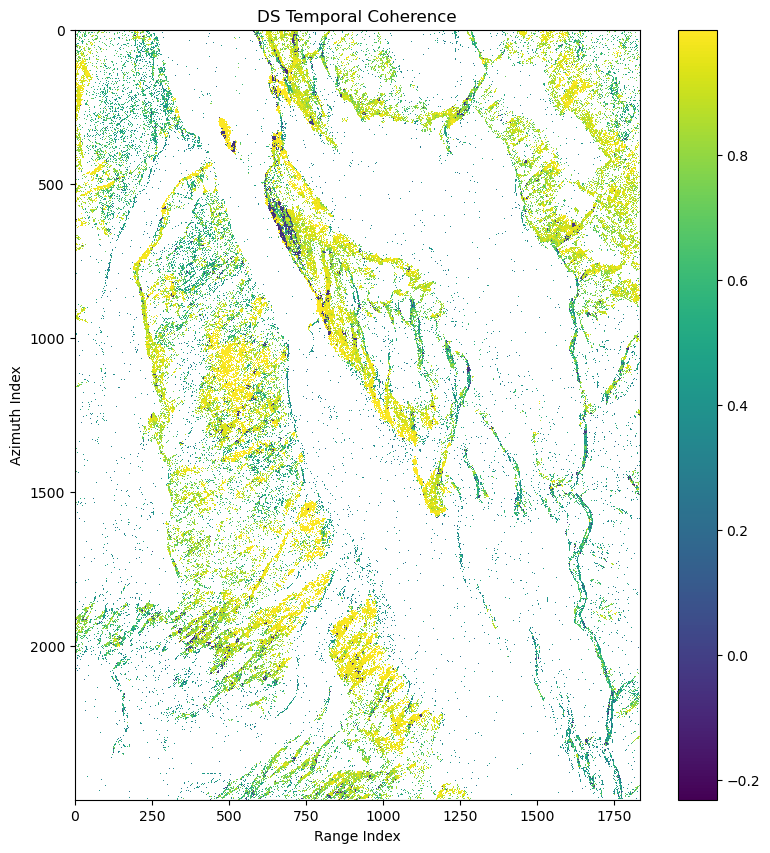

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
pcm = ax.imshow(cp.asnumpy(ds_can_temp_coh_2d),interpolation='nearest')
ax.set(title='DS Temporal Coherence',xlabel='Range Index',ylabel='Azimuth Index')
fig.colorbar(pcm)
fig.show()

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()